<a href="https://colab.research.google.com/github/sahilkholkar/PROJECT/blob/main/Anomaly_Detection_in_Surveillance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
pip install pytorch-msssim


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [18]:
import os
import cv2
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.metrics import confusion_matrix, roc_curve, auc
from pytorch_msssim import SSIM

In [19]:
# ------------------ CONFIGURATION ------------------

VIDEO_BASE_PATH = '/content/drive/MyDrive/Anomaly Detection in Surveillance/Videos/Videos'
NORMAL_CLASSES = ['walk', 'stand', 'sit', 'run']
ANOMALY_CLASSES = ['struggle', 'throw', 'sneak', 'lying_down', 'hit', 'kick', 'gun', 'grab', 'fall']
FRAME_SIZE = (128, 128)
MAX_FRAMES = 100
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 1e-4

In [20]:
# ------------------ FRAME EXTRACTION ------------------

def extract_frames(video_path, output_dir, label, max_frames=MAX_FRAMES):
    cap = cv2.VideoCapture(video_path)
    count = 0
    while cap.isOpened() and count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, FRAME_SIZE)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        filename = os.path.join(output_dir, f"{label}_{os.path.basename(video_path)[:-4]}_{count}.jpg")
        cv2.imwrite(filename, frame)
        count += 1
    cap.release()

# Only run once
os.makedirs('data/train/normal', exist_ok=True)
os.makedirs('data/test/normal', exist_ok=True)
os.makedirs('data/test/anomaly', exist_ok=True)

for action_class in os.listdir(VIDEO_BASE_PATH):
    class_path = os.path.join(VIDEO_BASE_PATH, action_class)
    if not os.path.isdir(class_path): continue
    for video_file in os.listdir(class_path):
        if not (video_file.endswith('.mp4') or video_file.endswith('.avi')): continue
        video_path = os.path.join(class_path, video_file)
        if action_class in NORMAL_CLASSES:
            extract_frames(video_path, 'data/train/normal', action_class)
            extract_frames(video_path, 'data/test/normal', action_class)
        elif action_class in ANOMALY_CLASSES:
            extract_frames(video_path, 'data/test/anomaly', action_class)

print("✅ Frame extraction complete.")

✅ Frame extraction complete.


In [21]:
# ------------------ DATASET CLASS ------------------

class FrameDataset(Dataset):
    def __init__(self, folder):
        self.files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.jpg')]
        self.transform = transforms.Compose([
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert('L')
        img = self.transform(img)
        noisy = img + 0.05 * torch.randn_like(img)
        noisy = torch.clamp(noisy, 0., 1.)
        return noisy, img

In [22]:
# ------------------ MODEL ------------------

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1), nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

In [23]:
# ------------------ TRAINING ------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvAutoencoder().to(device)

train_dataset = FrameDataset('data/train/normal')
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

criterion = SSIM(data_range=1.0, size_average=True, channel=1)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("🔁 Starting training...")

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for noisy_imgs, clean_imgs in train_loader:
        noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
        outputs = model(noisy_imgs)
        loss = 1 - criterion(outputs, clean_imgs)  # SSIM gives similarity, so use (1 - SSIM)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * noisy_imgs.size(0)

    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {total_loss/len(train_loader.dataset):.6f}")

🔁 Starting training...
Epoch [1/20], Loss: 0.357368
Epoch [2/20], Loss: 0.241334
Epoch [3/20], Loss: 0.214717
Epoch [4/20], Loss: 0.198103
Epoch [5/20], Loss: 0.185627
Epoch [6/20], Loss: 0.175758
Epoch [7/20], Loss: 0.168471
Epoch [8/20], Loss: 0.162935
Epoch [9/20], Loss: 0.158472
Epoch [10/20], Loss: 0.154470
Epoch [11/20], Loss: 0.150903
Epoch [12/20], Loss: 0.147675
Epoch [13/20], Loss: 0.144685
Epoch [14/20], Loss: 0.141707
Epoch [15/20], Loss: 0.138862
Epoch [16/20], Loss: 0.136241
Epoch [17/20], Loss: 0.133816
Epoch [18/20], Loss: 0.131522
Epoch [19/20], Loss: 0.129417
Epoch [20/20], Loss: 0.127545


In [24]:
# ------------------ ANOMALY DETECTION ------------------

class TestDataset(Dataset):
    def __init__(self, folder):
        self.files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.jpg')]
        self.transform = transforms.Compose([
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert('L')
        return self.transform(img)

def detect_anomalies(folder):
    dataset = TestDataset(folder)
    loader = DataLoader(dataset, batch_size=1)
    errors, labels = [], []

    model.eval()
    with torch.no_grad():
        for img in loader:
            img = img.to(device)
            output = model(img)
            loss = 1 - criterion(output, img)
            errors.append(loss.item())
            labels.append(0 if 'normal' in folder else 1)

    return errors, labels

# Run detection
normal_errors, normal_labels = detect_anomalies('data/test/normal')
anomaly_errors, anomaly_labels = detect_anomalies('data/test/anomaly')

all_errors = normal_errors + anomaly_errors
all_labels = normal_labels + anomaly_labels

In [25]:
# ------------------ EVALUATION ------------------

print(f"\nAverage normal error: {np.mean(normal_errors):.4f}")
print(f"Average anomaly error: {np.mean(anomaly_errors):.4f}")

threshold = np.percentile(normal_errors, 95)
predicted = [1 if e > threshold else 0 for e in all_errors]

conf_matrix = confusion_matrix(all_labels, predicted)
print("\nConfusion Matrix:")
print(conf_matrix)

fpr, tpr, _ = roc_curve(all_labels, all_errors)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC: {roc_auc:.4f}")


Average normal error: 0.0987
Average anomaly error: 0.1025

Confusion Matrix:
[[ 66543   3503]
 [124802   7173]]
ROC AUC: 0.5232


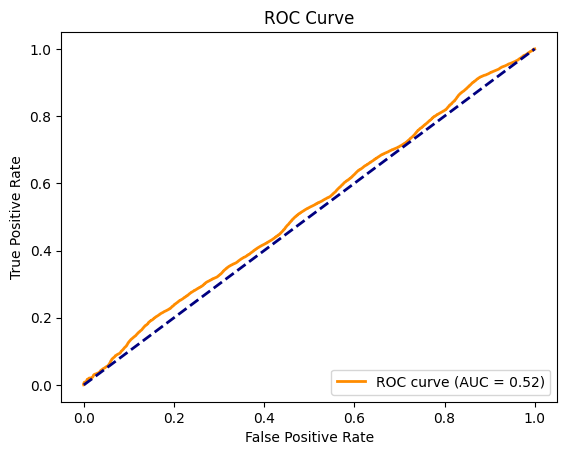

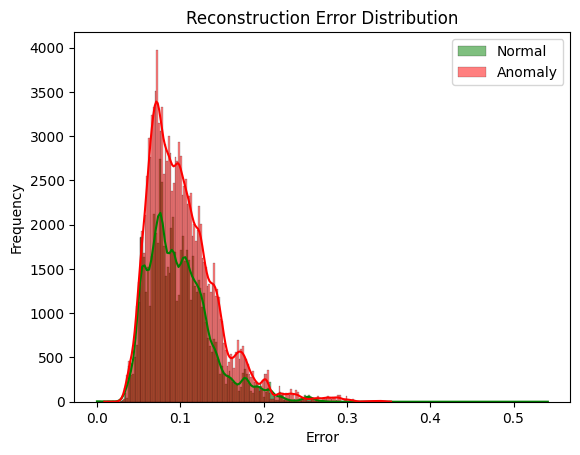

In [26]:
# ------------------ PLOTTING ------------------

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Error Distributions
sns.histplot(normal_errors, label='Normal', color='green', kde=True)
sns.histplot(anomaly_errors, label='Anomaly', color='red', kde=True)
plt.legend()
plt.title("Reconstruction Error Distribution")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()


🔍 Visualizing reconstructions for normal and anomaly frames...



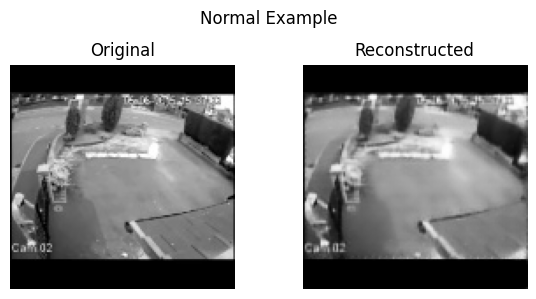

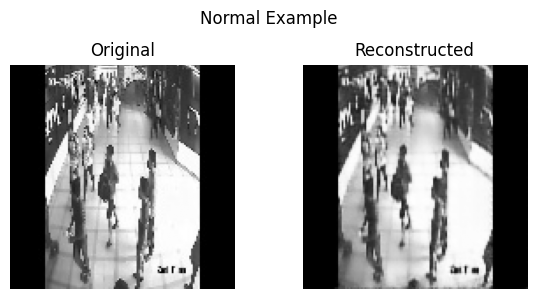

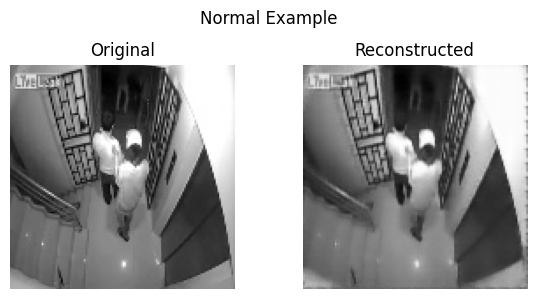

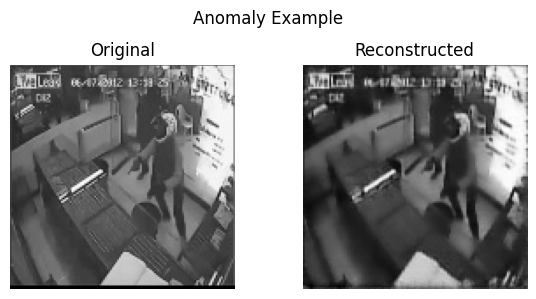

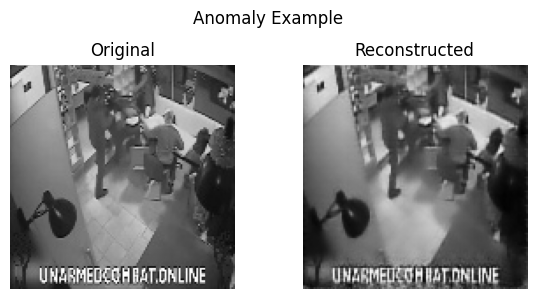

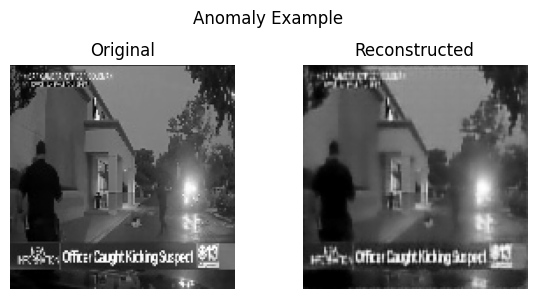

In [27]:
# ------------------ VISUALIZATION: RECONSTRUCTION COMPARISON ------------------

def show_reconstructions(folder, title):
    dataset = TestDataset(folder)
    loader = DataLoader(dataset, batch_size=1, shuffle=True)
    model.eval()
    shown = 0

    for img in loader:
        img = img.to(device)
        with torch.no_grad():
            output = model(img)

        img_np = img.squeeze().cpu().numpy()
        output_np = output.squeeze().cpu().numpy()

        # Plot original vs reconstructed
        fig, axs = plt.subplots(1, 2, figsize=(6, 3))
        axs[0].imshow(img_np, cmap='gray')
        axs[0].set_title("Original")
        axs[0].axis('off')

        axs[1].imshow(output_np, cmap='gray')
        axs[1].set_title("Reconstructed")
        axs[1].axis('off')

        plt.suptitle(f"{title} Example")
        plt.tight_layout()
        plt.show()

        shown += 1
        if shown >= 3:  # Show 3 examples
            break

print("\n🔍 Visualizing reconstructions for normal and anomaly frames...\n")
show_reconstructions('data/test/normal', "Normal")
show_reconstructions('data/test/anomaly', "Anomaly")
